In [1]:
from google.colab import files
data = files.upload()

Saving ankleAngle.csv to ankleAngle (1).csv


In [0]:
import pandas as pd
adata= pd.read_csv("ankleAngle.csv",usecols=[1], names=['ankleData'])

In [0]:
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [4]:
adata.describe()


,ankleData
count,6489.000000
mean,0.033636
std,0.190928
min,-0.436360
25%,0.020682
50%,0.068223
75%,0.177084
max,0.215836


In [0]:
data = adata.values

In [6]:
data

array([[-0.43633231],
       [-0.43633231],
       [-0.43633231],
       ...,
       [ 0.20201225],
       [ 0.20405303],
       [ 0.20593505]])

In [0]:
data = data.astype('float32')


In [8]:
data.shape

(6489, 1)

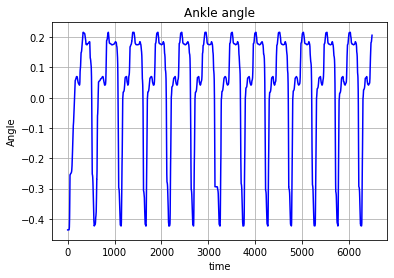

In [9]:
plt.plot(adata, color='blue')
plt.title("Ankle angle")
plt.xlabel('time')
plt.ylabel('Angle')
plt.grid(True)
plt.show()

In [0]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

In [0]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 7)

In [12]:
X_train = np.array(X[1018:])
y_train = np.array(y[1018:])

X_test  = np.array(X[:1018])
y_test = np.array(y[:1018])



print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (5464, 7, 1)
y_train size: (5464, 1)
X_test size: (1018, 7, 1)
y_test size: (1018, 1)


In [0]:
batch_size = 7 
window_size = 8 
hidden_layer = 50
clip_margin = 3
learning_rate = 0.001 
epochs = 10

In [0]:
tf.compat.v1.disable_eager_execution()

In [0]:
inputs = tf.placeholder(tf.float32, [batch_size,batch_size, 1])
targets = tf.placeholder(tf.float32, [batch_size,1])

In [16]:
#weights for input vector
wr = tf.Variable(tf.truncated_normal(shape=(1,hidden_layer),stddev=0.05,dtype=tf.float32), name = "wr")
wz = tf.Variable(tf.truncated_normal(shape=(1,hidden_layer),stddev=0.05,dtype=tf.float32) ,name = "wz")
wh = tf.Variable(tf.truncated_normal(shape=(1,hidden_layer),stddev=0.05,dtype=tf.float32) ,name = "wh")

#weights for hidden vector
ur = tf.Variable(tf.truncated_normal(shape=(hidden_layer,hidden_layer),stddev=0.05,dtype=tf.float32) ,name = "ur")
uz = tf.Variable(tf.truncated_normal(shape=(hidden_layer,hidden_layer),stddev=0.05,dtype=tf.float32) ,name = "ur")
uh = tf.Variable(tf.truncated_normal(shape=(hidden_layer,hidden_layer),stddev=0.05,dtype=tf.float32), name = "ur")

#bias for hidden vector
br = tf.Variable(tf.truncated_normal(shape=(hidden_layer,),stddev=0.05,dtype=tf.float32) ,name = "br")
bz = tf.Variable(tf.truncated_normal(shape=(hidden_layer,),stddev=0.05,dtype=tf.float32),name = "bz")
bh = tf.Variable(tf.truncated_normal(shape=(hidden_layer,),stddev=0.05,dtype=tf.float32),name = "bh")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def GRU_Cell(input , output):
  z = tf.sigmoid(tf.matmul(input,wz) + tf.matmul(output,uz) + bz)

  r = tf.sigmoid(tf.matmul(input,wr) + tf.matmul(output,ur) + br)
 
  
  h_p = tf.tanh(tf.matmul(input,wh) + tf.matmul(r*output,uh) + bh) 

  h =(1-z)*(output) + z*h_p
  return h

In [0]:
w_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
b_output = tf.Variable(tf.zeros([1]))

In [19]:
inputs.shape

TensorShape([7, 7, 1])

In [20]:
outputs = []
for i in range(batch_size): 
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, 50], dtype=np.float32)
    for ii in range(batch_size):
        batch_output = GRU_Cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_output)
    outputs.append(tf.matmul(batch_output, w_output) + b_output)
outputs

[<tf.Tensor 'add_49:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_99:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_149:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_199:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_249:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_299:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_349:0' shape=(1, 1) dtype=float32>]

In [0]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

In [0]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [24]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 2) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/10  Current loss: 0.12958574295043945
Epoch 2/10  Current loss: 0.011124162003397942
Epoch 4/10  Current loss: 0.005079153925180435
Epoch 6/10  Current loss: 0.00320763629861176
Epoch 8/10  Current loss: 0.0018757557263597846


In [0]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [0]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
  i += batch_size
  tests.append(o)

In [0]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [0]:
test_results = []
for i in range(1264):
      if i >= 1019:
        test_results.append(tests_new[i-1019])
      else:
        test_results.append(None)

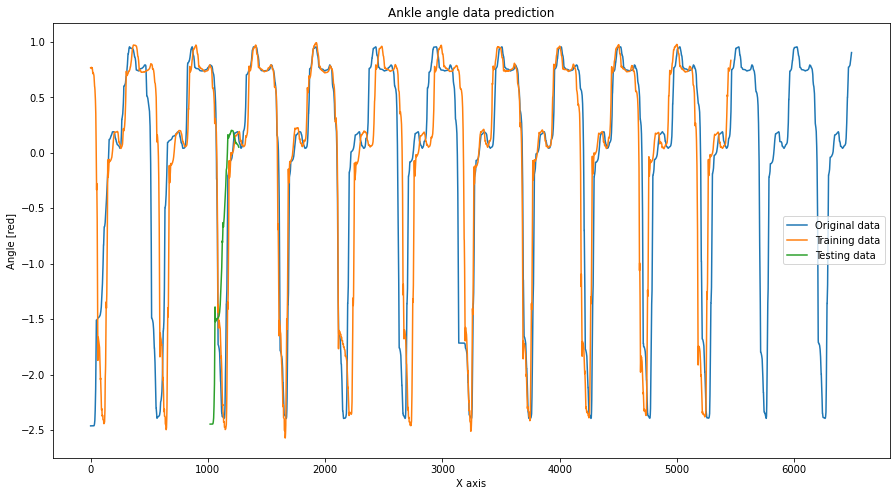

In [29]:
plt.figure(figsize=(15, 8))
plt.title('Ankle angle data prediction')
plt.xlabel('X axis')
plt.ylabel('Angle [red]')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()